<h1><center>Машинное обучение. Предсказание промышленного индекса Доу-Джонса по заголовкам новостей на датасете</center></h1>
<center>Никишина Ирина, Бакаров Амир</center>
<center>Национальный исследовательский университет "Высшая школа экономики"</center>

In [343]:
from pandas import DataFrame, concat, options
from nltk.corpus import stopwords
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD

# import torch
# from torch import nn
# import torch.nn.functional as F
# from skorch.net import NeuralNetClassifier
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')
stop = stopwords.words('english')
options.mode.chained_assignment = None

Загружаем данные

In [2]:
data = DataFrame.from_csv('stocknews/Combined_News_DJIA.csv').reset_index().fillna(' ')

In [3]:
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']
y_train = train.Label.values
y_test = test.Label.values

In [361]:
col_number = 26

### Предобработка

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг.

In [310]:
lmb_f = [lambda x: re.sub("""^b("|')""",'', str(x)), 
         lambda x: str(x).lower(),
         lambda x: str(x).replace("'",''),
         lambda x: word_tokenize(str(x)),
         lambda x: [wordnet_lemmatizer.lemmatize(str(i)) for i in x]
        ]

In [311]:
def parse_trainset(data):
    li = []
    for col in range(1, col_number):
        s = data.loc[:,'Top' + str(col)]
        for a in lmb_f:
            s = s.apply(a)
        li.append(s)
    return li

In [312]:
trainset_parsed = DataFrame(parse_trainset(train)).transpose()
testset_parsed = DataFrame(parse_trainset(test)).transpose()

In [313]:
train_ = concat([train.drop(train.columns[2:], axis=1), trainset_parsed], axis=1)
test_ = concat([test.drop(test.columns[2:], axis=1), testset_parsed], axis=1)

### Анализ данных
Ответьте на следующие вопросы:

Есть ли корреляция между средней длинной текста за день и DJIA?

In [314]:
mean_list = []
for number in range(train_.shape[0]):
    s = np.mean([len(f) for f in list(train_.loc[number][2:].values)])
    mean_list.append((s, y_train[number]))

for number2 in range(number+1, number+1+test_.shape[0]):
    s = np.mean([len(f) for f in list(test_.loc[number2][2:].values)])
    mean_list.append((s, y_test[number2-number-1]))
mean_list = sorted(mean_list)

C:\Users\Irina\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


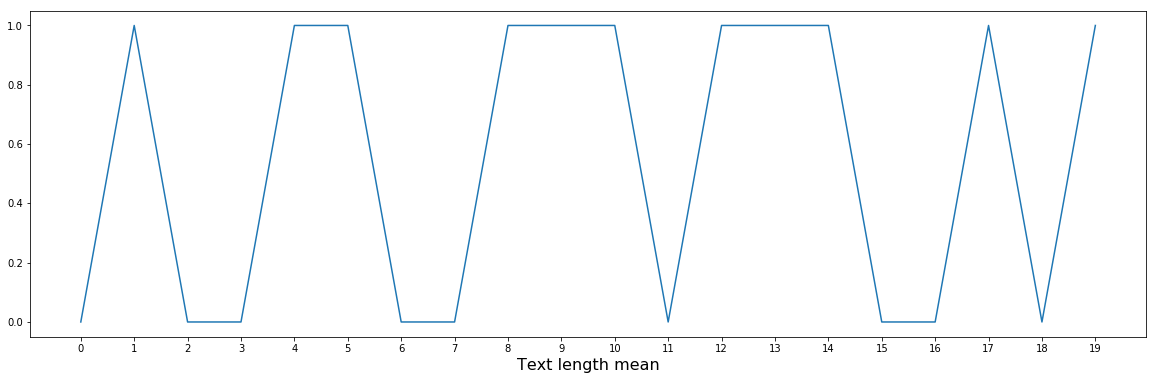

In [315]:
plt.figure(figsize=(20,6))
plt.plot(range(len(mean_list))[:20], list(y_train)[:20])
plt.legend()
plt.xticks(range(20))
#plt.xticks([0,500,1000, 1500, 2000], ['9', '15', '20', '25', '30'])
plt.xlabel("Text length mean", size=16)
plt.show()

Есть ли корреляция между количеством упоминаний Барака Обамы и США в день и DJIA? Учтите разные варианты написания США.

In [316]:
lists = ['obama', 'us','u.s.', 'u s','u.s', 'united', 'state', 'america']
from collections import Counter
all_sum = []
for number in range(train_.shape[0]):
    s = [i for f in list(train_.loc[number][2:].values) for i in f]
    summ = 0
    for i in lists:
        summ+=Counter(s)[i]
    all_sum.append((summ, y_train[number]))

for number2 in range(number+1, number+1+test_.shape[0]):
    s = [i for f in list(test_.loc[number2][2:].values) for i in f]
    summ = 0
    for i in lists:
        summ+=Counter(s)[i]
    all_sum.append((summ, y_test[number2-number-1]))

[152, 221, 210, 136, 94, 59, 29, 16, 3, 1, 2, 1]
[168, 241, 252, 148, 107, 79, 37, 15, 10, 6, 1, 1]


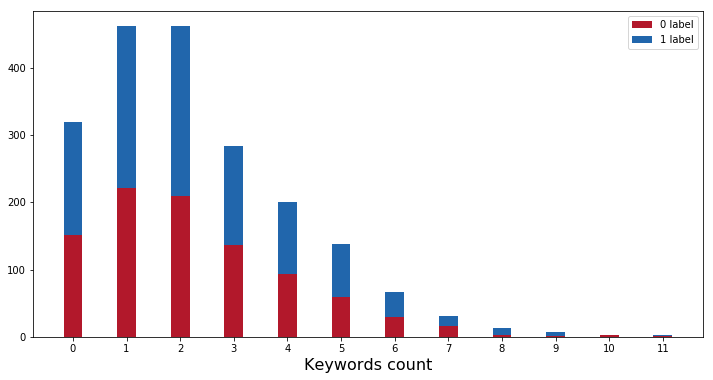

In [317]:
a = sorted([(i[0], dict(Counter(all_sum))[i]) for i in dict(Counter(all_sum)) if i[1]==0])
a1= [i[1] for i in a]
b = sorted([(i[0], dict(Counter(all_sum))[i]) for i in dict(Counter(all_sum)) if i[1]==1])
b1= [i[1] for i in b]
red = '#B2182B'
blue = '#2166AC'
width = 0.35
print(a1)
print(b1)
plt.figure(figsize=(12,6))
plt.bar(np.arange(12), a1, width, color=red, label="0 label")
plt.bar(np.arange(12), b1, width, bottom=a1, color=blue, label="1 label")
plt.legend()
plt.xticks(range(12))
plt.xlabel("Keywords count", size=16)
plt.show()

Каких статей больше: статей о России и Путине или об Исламском государстве (запрещенной законом РФ террористическая организации)?

In [318]:
new_s = []
for number in range(train_.shape[0]):
    new_s += [i for f in list(train_.loc[number][2:].values) for i in f]
for number2 in range(number+1, number+1+test_.shape[0]):
    new_s += [i for f in list(test_.loc[number2][2:].values) for i in f]
news_counter = Counter(new_s)
print('Articles about...')
print('...Russia =', news_counter['russia'])
print('...Russian =', news_counter['russian'])
print('...Putin =', news_counter['putin'])
print('------------------')
print('SUM  = ', news_counter['putin']+news_counter['russia']+news_counter['russian'])
print('------------------')
print()
print('Articles about...')
print('...ISIL =', news_counter['isil'])
print('...Iraq =', news_counter['iraq'])
print('...Syria =', news_counter['syria'])
print('...Islamic =', news_counter['islamic'])
print('------------------')
print('SUM  = ', news_counter['isil']+news_counter['iraq']+news_counter['syria']+news_counter['islamic'])
print('------------------')

Articles about...
...Russia = 1730
...Russian = 1257
...Putin = 550
------------------
SUM  =  3537
------------------

Articles about...
...ISIL = 54
...Iraq = 704
...Syria = 967
...Islamic = 554
------------------
SUM  =  2279
------------------


О каких кризисах (crisis) пишут статьи?

In [322]:
list_of_crisis = []
for ind in range(train_.shape[0]):
    list_of_articles = list(train_.loc[ind])[2:]
    for i in list_of_articles:
        if 'crisis' in i:
            try:
                word = nltk.pos_tag([i[i.index('crisis')-1]])[0]
                if word[1]=='JJ':
                    list_of_crisis.append(word[0])
            except Exception as e:
                pass

for ind2 in range(ind+1, test_.shape[0]+1):
    list_of_articles = list(test_.loc[ind2])[2:]
    for i in list_of_articles:
        if 'crisis' in i:
            try:
                word = nltk.pos_tag([i[i.index('crisis')-1]])[0]
                if word[1]=='JJ':
                    list_of_crisis.append(word[0])
            except Exception as e:
                pass
            
print(set(list_of_crisis))

{'current', 'political', 'difficult', 'georgian', 'serious', 'demographic', 'diplomatic', 'european', 'ukrainian', 'global', 'total', 'huge', 'financial', 'economic', 'syrian', 'nuclear', 'humanitarian', 'fundamental', 'italian'}


### Простые фичи

In [362]:
lambda_func_features = [
    (lambda x: len(str(x).split()), 'NumWords'),
    (lambda x: len(set(str(x).split())), 'NumUniqueWords'),
    (lambda x: len(str(x)), 'NumChars'),
    (lambda x: len([w for w in str(x).lower().split() if w in stop]), 'NumStopWords'),
    (lambda x: np.mean([len(w) for w in str(x).split()]), 'MeanWordLen')
]

In [6]:
def generate_features(train, test, lambda_func, func_name):
    train_features = DataFrame([train.loc[:,'Top' + str(col)].apply(lambda_func) for col in range(1, col_number)]).transpose()
    test_features = DataFrame([test.loc[:,'Top' + str(col)].apply(lambda_func) for col in range(1, col_number)]).transpose()
    train_features.columns = [func_name + str(i) for i in range(1, col_number)]
    test_features.columns = [func_name + str(i) for i in range(1, col_number)]
    return concat([train, train_features], axis=1), concat([test, test_features], axis=1)

In [364]:
for lambda_func, func_name in lambda_func_features:
    train, test = generate_features(train, test, lambda_func, func_name)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x2BD512B0>>
Traceback (most recent call last):
  File "C:\Users\Irina\Anaconda3\lib\site-packages\xgboost\core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


### Фичи на основе предсказаний классификаторов на векторизаторах

In [365]:
def make_raw_text_col(df):
    df['text'] = df['Top1'].str[1:] + ' '
    for i in df.loc[:,'Top2':'Top25']:
        df['text'] += df[i].str[1:] + ' '
    df['text'] = df['text'].str.lower().str.replace('[^a-zA-Z ]', '')
    return df
    
train = make_raw_text_col(train)
test = make_raw_text_col(test)

In [9]:
vectorizers = [
    (CountVectorizer(stop_words='english', ngram_range=(1,3)), 'CountVectorizer'),
    (TfidfVectorizer(ngram_range=(1,5), analyzer='char'), 'TfIdfVectorizerChar')
]

In [10]:
kfolds = 5

for vec, vec_name in vectorizers:
    vectorizer = vec
    full = vectorizer.fit_transform(np.hstack((train.text.values, test.text.values)))
    X_train = vectorizer.transform(train.text.values)
    X_test = vectorizer.transform(test.text.values)

    pred_full_test = 0
    pred_train = np.zeros([train.shape[0], len(train.Label.unique())])

    for dev_index, val_index in KFold(n_splits=kfolds, shuffle=True, random_state=42).split(train):
        dev_X, val_X = X_train[dev_index], X_train[val_index]
        dev_y, val_y = y_train[dev_index], y_train[val_index]
        model = MultinomialNB()
        model.fit(dev_X, dev_y)
        pred_full_test = pred_full_test + model.predict_proba(X_test)
        pred_train[val_index,:] = model.predict_proba(val_X)

    pred_full_test = pred_full_test / kfolds

    train[vec_name + 'Zero'] = pred_train[:,0]
    train[vec_name + 'One'] = pred_train[:,1]
    test[vec_name + 'Zero'] = pred_full_test[:,0]
    test[vec_name + 'One'] = pred_full_test[:,1]

### Фичи на основе компонент векторов

In [11]:
svd_components = 20

vectorizer = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full = vectorizer.fit_transform(np.hstack((train.text.values, test.text.values)))
X_train = vectorizer.transform(train.text.values)
X_test = vectorizer.transform(test.text.values)

svd = TruncatedSVD(n_components=svd_components, algorithm='arpack')
svd.fit(full)
train_svd = DataFrame(svd.transform(X_train))
test_svd = DataFrame(svd.transform(X_test))
    
train_svd.columns = ['SVD' + str(i) for i in range(svd_components)]
test_svd.columns = ['SVD' + str(i) for i in range(svd_components)]

train = concat([train, train_svd], axis=1, join_axes=[train.index])
test = concat([test, test_svd], axis=1, join_axes=[test.index])

### Фичи сгенерированы, убираем лишнее

In [12]:
train = train.drop(train.columns[0:col_number+2], axis=1)
test = test.drop(test.columns[0:col_number+2], axis=1)
# train = train.drop('text', axis=1)
# test = test.drop('text', axis=1)

### Задаём параметры градиентного бустинга

In [13]:
params = {}
params['objective'] = 'multi:softprob'
params['eta'] = 0.1
params['max_depth'] = 3
params['silent'] = 1
params['num_class'] = 3
params['eval_metric'] = 'mlogloss'
params['min_child_weight'] = 1
params['subsample'] = 0.8
params['colsample_bytree'] = 0.3
params['seed'] = 0

### Классификация

Градиентный бустинг

In [43]:
boost_rounds = 20
kfolds = 5
pred_full_test = 0
pred_train = np.zeros([train.shape[0], len(set(y_train))])
for dev_index, val_index in KFold(n_splits=kfolds, shuffle=True, random_state=42).split(train):
    dev_X, val_X = train.loc[dev_index], train.loc[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    xgtrain = xgb.DMatrix(dev_X, dev_y)
    xgtest = xgb.DMatrix(test)
    model = xgb.train(params=list(params.items()), dtrain=xgtrain, num_boost_round=boost_rounds)
    predictions = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    pred_full_test = pred_full_test + predictions
pred_full_test = pred_full_test / kfolds

Простые классификаторы

In [375]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train, y_train)
res_clf_labels = clf.predict(test)

In [378]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier()
rf = rf.fit(train, y_train)
res_rf_labels = rf.predict(test)

In [372]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(train, y_train)
res_gnb_labels = gnb.predict(test)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn import svm, model_selection
svc = LinearSVC()
svc = do_grid_search(train, y_train)
svc = svc.fit(train, y_train)
res_svc_labels = svc.predict(test)

Подбор оптимальных гиперпараметров

In [384]:
def do_grid_search(array_of_vectors, array_of_tags, parameters=None):
    if not parameters:
        parameters = {'penalty': ('l1', 'l2'), 'loss': ('hinge', 'squared_hinge'),
                      'multi_class': ('ovr', 'crammer_singer'), 'C': [0.01, 0.1, 1, 10]}
    cl = model_selection.GridSearchCV(svc, parameters, error_score=0.0)
    cl.fit(array_of_vectors, array_of_tags)
    print(cl.best_estimator_)
    return cl.best_estimator_

### Считаем результаты

Текстовые фичи

In [368]:
f1_score(pred_full_test.argmax(axis=1), y_test) 

0.67034990791896865

Фичи на компонентах векторов

In [369]:
accuracy_score(pred_full_test.argmax(axis=1), y_test) 

0.52645502645502651

Фичи с вероятностями на векторизации

In [376]:
f1_score(res_clf_labels, y_test) 

0.54773869346733672

Другие классификаторы:

In [379]:
f1_score(res_rf_labels, y_test) 

0.52736318407960192

In [374]:
accuracy_score(res_gnb_labels, y_test) 

0.53703703703703709

In [377]:
accuracy_score(res_clf_labels, y_test) 

0.52380952380952384

In [380]:
accuracy_score(res_rf_labels, y_test) 

0.49735449735449733

In [381]:
print(f1_score(res_svc_labels, y_test))
print(accuracy_score(res_svc_labels, y_test))

0.558603491272
0.531746031746
